In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import pandas as pd
import math
import xgboost as xgb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import compute_sample_weight

## Splitting data into a training and validation set

In [ ]:
train = pd.read_csv('train.csv').drop(columns=['S.No','PSL','TREFHT','time'])
test = pd.read_csv('test.csv').drop(columns=['S.No','PSL','TREFHT','time'])
X = train.drop(columns='LABELS')
y = train.loc[:,['LABELS']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=1, stratify=y)

## Normalization of the training and test points

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

## Instantiation of the model

In [ ]:
model = xgb.XGBClassifier()
param_grid = {'objective':['multi:softprob'],
             'eval_metric':['mlogloss'],
             'use_label_encoder':[False],
             'n_jobs':[-1],
             'random_state':[1],
             'num_class':[y_train.LABELS.nunique()],
             'n_estimators':[10000],
             'tree_method':['gpu_hist']}

In [ ]:
 %%time
sample_weight = compute_sample_weight('balanced', y_train)
cv = StratifiedKFold(n_splits=5,shuffle=True)
search = GridSearchCV(model,param_grid,scoring='balanced_accuracy',cv=cv,refit=False,error_score='raise')
fit = search.fit(X_train_norm,np.ravel(y_train),sample_weight=sample_weight)

CPU times: user 24min 52s, sys: 2.5 s, total: 24min 55s
Wall time: 6min 17s


## Plotting the learning curves with respect to the evaluation metric

In [ ]:
%%time
evaluation_set = [(X_train_norm,np.ravel(y_train)),(X_val_norm,np.ravel(y_val))]
best_params = fit.best_params_
model.set_params(**best_params)

CPU times: user 107 µs, sys: 0 ns, total: 107 µs
Wall time: 111 µs


In [ ]:
# Refit model
model = model.fit(X_train_norm,np.ravel(y_train),eval_metric=['merror','mlogloss'],eval_set=evaluation_set,verbose=False,early_stopping_rounds=10,sample_weight=sample_weight)
eval_results = model.evals_result()
# Epochs
epochs = np.arange(len(eval_results['validation_1']['mlogloss']))

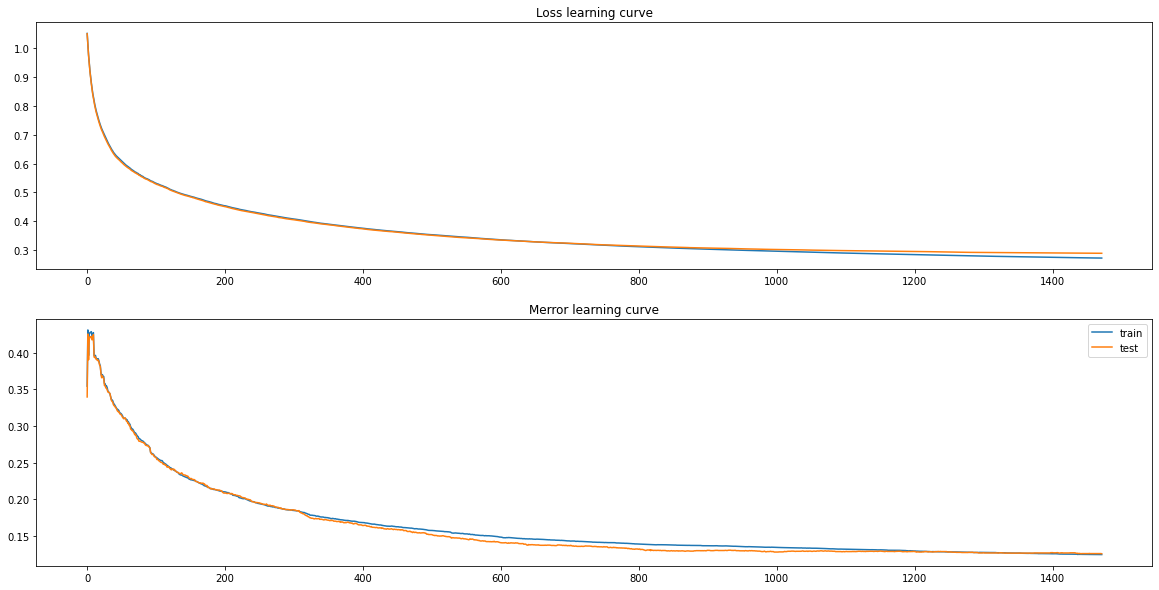

In [ ]:
fig,axes = plt.subplots(2,figsize=(20,10))
axes[0].plot(epochs, eval_results['validation_0']['mlogloss'],label='train')
axes[0].plot(epochs, eval_results['validation_1']['mlogloss'],label='test')
axes[0].set_title('Loss learning curve')
axes[1].plot(epochs, eval_results['validation_0']['merror'],label='train')
axes[1].plot(epochs, eval_results['validation_1']['merror'],label='test')
axes[1].set_title('Merror learning curve')
plt.legend()
plt.show()

## Computing the accuracy of the model on the validation set

In [ ]:
val_preds = model.predict(X_val_norm)
accuracy = accuracy_score(y_val,val_preds)
print('Accuracy: {}%'.format(np.around(accuracy*100, 2)))

Accuracy: 87.4%


## Data visualization

In [ ]:
print(classification_report(y_val,val_preds))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3754
           1       0.61      0.92      0.73       200
           2       0.64      0.92      0.76       822

    accuracy                           0.87      4776
   macro avg       0.74      0.90      0.80      4776
weighted avg       0.91      0.87      0.88      4776



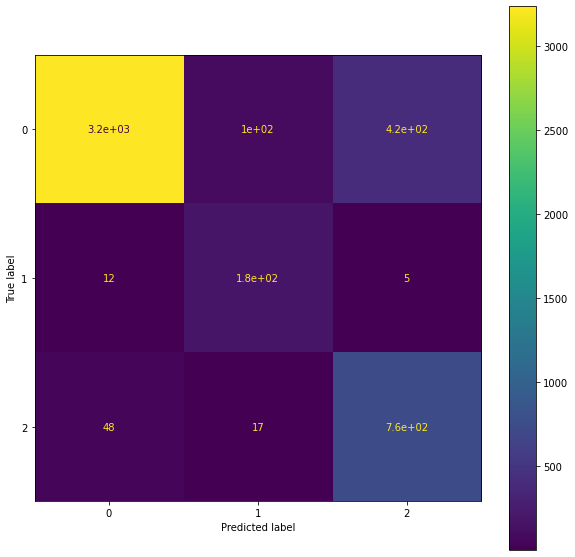

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model,X_val_norm,y_val, ax=ax)
plt.show()

## Predicting our test set labels

In [ ]:
test_norm = scaler.transform(test)
test_labels = model.predict(test_norm)

In [ ]:
df_submission = pd.DataFrame({'LABELS':test_labels})
df_submission.reset_index(inplace=True)
df_submission.rename(columns={'index':'S.No'},inplace=True)

In [ ]:
df_submission.LABELS.value_counts()

0    4934
2    1733
1     653
Name: LABELS, dtype: int64

In [ ]:
df_submission.LABELS.value_counts()
df_submission.to_csv('predictions_weighted.csv',index=False)